LOAD DATA

In [6]:
import os
import cv2
import numpy as np

DATASET_PATH = "C:/Users/LENOVO/Downloads/KA/Brain_Stroke_CT_Dataset"

images = []
labels = []

class_names = sorted(os.listdir(DATASET_PATH))  
print("Detected classes:", class_names)

for label_name in class_names:
    folder_path = os.path.join(DATASET_PATH, label_name)
    
    if not os.path.isdir(folder_path):
        continue
    
    for filename in os.listdir(folder_path):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(folder_path, filename)
            
            img = cv2.imread(img_path)
            
            if img is None:
                continue
            
            images.append(img)
            labels.append(label_name)

images = np.array(images, dtype=object)
labels = np.array(labels)

print("Dataset Loaded:")
print(f"- Total gambar: {len(images)}")
print(f"- Total label: {len(labels)}")


Detected classes: ['Bleeding', 'Ischemia', 'Normal']
Dataset Loaded:
- Total gambar: 6650
- Total label: 6650


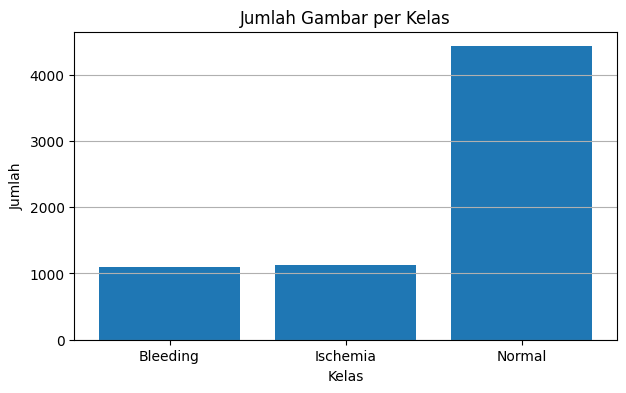

In [3]:
import matplotlib.pyplot as plt
from collections import Counter

count = Counter(labels)

plt.figure(figsize=(7,4))
plt.bar(count.keys(), count.values())
plt.title("Jumlah Gambar per Kelas")
plt.xlabel("Kelas")
plt.ylabel("Jumlah")
plt.grid(axis='y')
plt.show()


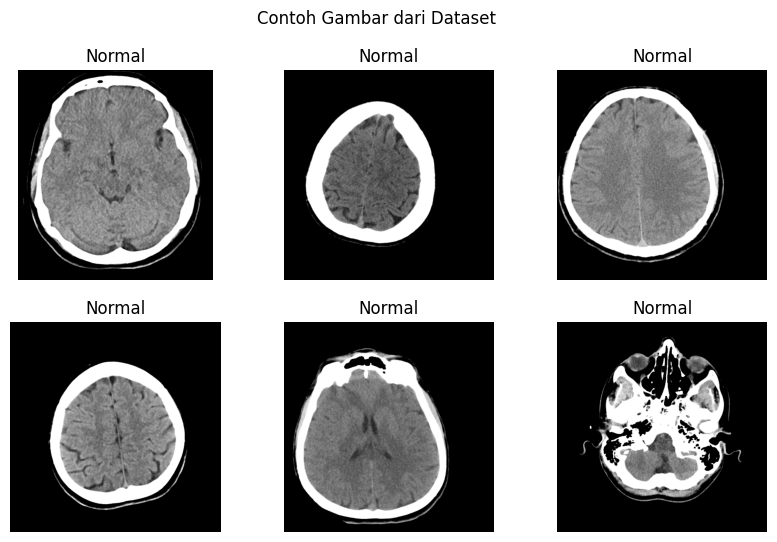

In [4]:
import random

plt.figure(figsize=(10,6))
for i in range(6):
    idx = random.randint(0, len(images)-1)
    img = cv2.cvtColor(images[idx], cv2.COLOR_BGR2RGB)
    plt.subplot(2,3,i+1)
    plt.imshow(img)
    plt.title(labels[idx])
    plt.axis("off")

plt.suptitle("Contoh Gambar dari Dataset")
plt.show()


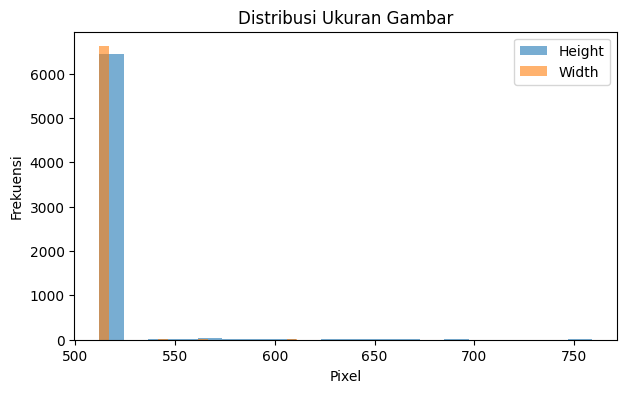

In [5]:
heights = []
widths = []

for img in images:
    h, w = img.shape[:2]
    heights.append(h)
    widths.append(w)

plt.figure(figsize=(7,4))
plt.hist(heights, bins=20, alpha=0.6, label="Height")
plt.hist(widths, bins=20, alpha=0.6, label="Width")
plt.title("Distribusi Ukuran Gambar")
plt.xlabel("Pixel")
plt.ylabel("Frekuensi")
plt.legend()
plt.show()


STEP 2 — PREPROCESSING (Resize + Optional Grayscale)

In [6]:
import cv2
import numpy as np

processed_images = []

TARGET_SIZE = (128, 128)
USE_GRAYSCALE = False    

for img in images:
    img = np.array(img)  
    resized = cv2.resize(img, TARGET_SIZE)

    if USE_GRAYSCALE:
        resized = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)
    
    processed_images.append(resized)

processed_images = np.array(processed_images)

print("Preprocessing selesai!")
print(f"Total gambar: {len(processed_images)}")
print(f"Bentuk gambar contoh: {processed_images[0].shape}")


Preprocessing selesai!
Total gambar: 6650
Bentuk gambar contoh: (128, 128, 3)


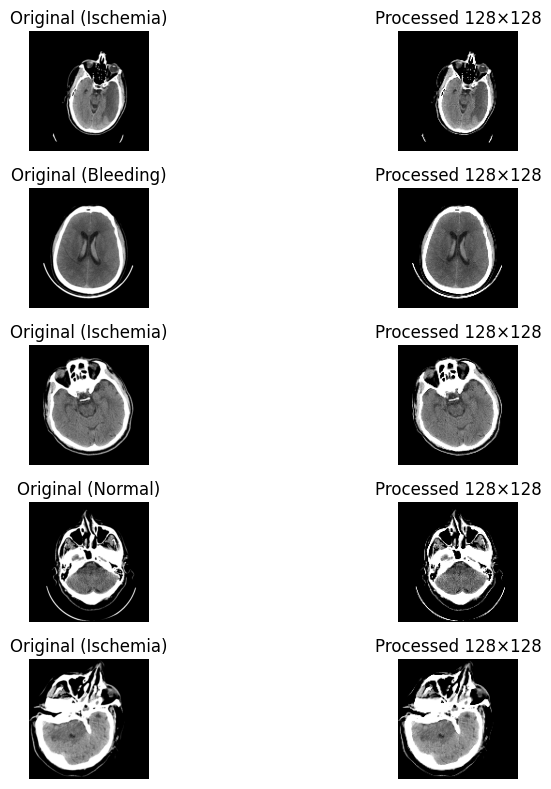

In [7]:
import matplotlib.pyplot as plt
import random
import numpy as np
import cv2

plt.figure(figsize=(10,8))

for i in range(5):
    idx = random.randint(0, len(images)-1)
    
    original = np.array(images[idx])
    if len(original.shape) == 3 and original.shape[2] == 3:
        original = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)
    
    processed = np.array(processed_images[idx])
    if USE_GRAYSCALE or (len(processed.shape) == 2):
        cmap = "gray"
    else:
        processed = cv2.cvtColor(processed, cv2.COLOR_BGR2RGB)
        cmap = None
    
    plt.subplot(5,2,2*i+1)
    plt.imshow(original)
    plt.title(f"Original ({labels[idx]})")
    plt.axis("off")
    
    plt.subplot(5,2,2*i+2)
    plt.imshow(processed, cmap=cmap)
    plt.title("Processed 128×128")
    plt.axis("off")

plt.tight_layout()
plt.show()


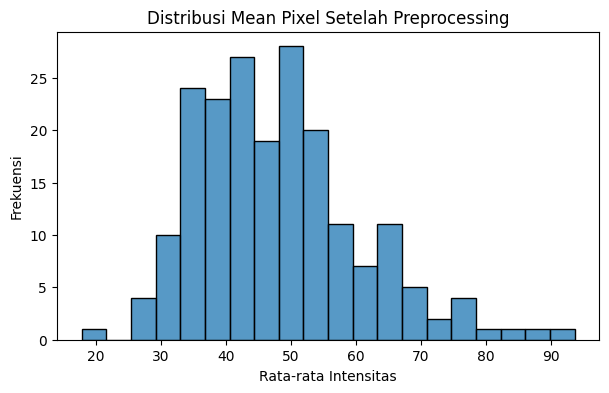

In [8]:
import seaborn as sns

sample_idx = np.random.choice(len(processed_images), 200, replace=False)

avg_pixels = [processed_images[i].mean() for i in sample_idx]

plt.figure(figsize=(7,4))
sns.histplot(avg_pixels, bins=20)
plt.title("Distribusi Mean Pixel Setelah Preprocessing")
plt.xlabel("Rata-rata Intensitas")
plt.ylabel("Frekuensi")
plt.show()


In [25]:
if USE_GRAYSCALE:
    plt.figure(figsize=(5,5))
    plt.imshow(processed_images[0], cmap="hot")
    plt.title("Heatmap Grayscale")
    plt.axis("off")
    plt.show()

STEP 3 — Ekstraksi Fitur (HOG + LBP + Color Histogram)

In [9]:
from skimage.feature import hog, local_binary_pattern
import cv2
import numpy as np
from tqdm import tqdm

LBP_RADIUS = 2
LBP_POINTS = 8 * LBP_RADIUS

hog_features = []
lbp_features = []
color_features = []

for img in tqdm(processed_images, desc="Extracting Features"):

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    hog_feat = hog(
        gray,
        orientations=9,
        pixels_per_cell=(8, 8),
        cells_per_block=(2, 2),
        block_norm='L2-Hys',
        transform_sqrt=True
    )
    hog_features.append(hog_feat)

    lbp = local_binary_pattern(gray, LBP_POINTS, LBP_RADIUS, method='uniform')
    (hist, _) = np.histogram(
        lbp.ravel(),
        bins=np.arange(0, LBP_POINTS + 3),
        range=(0, LBP_POINTS + 2)
    )
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-6)
    lbp_features.append(hist)

    hist_b = cv2.calcHist([img], [0], None, [32], [0, 256])
    hist_g = cv2.calcHist([img], [1], None, [32], [0, 256])
    hist_r = cv2.calcHist([img], [2], None, [32], [0, 256])
    
    hist_color = np.concatenate([
        hist_b.flatten(),
        hist_g.flatten(),
        hist_r.flatten()
    ])
    
    hist_color = hist_color / (np.sum(hist_color) + 1e-6)
    
    color_features.append(hist_color)

hog_features = np.array(hog_features)
lbp_features = np.array(lbp_features)
color_features = np.array(color_features)

print("HOG shape:", hog_features.shape)
print("LBP shape:", lbp_features.shape)
print("Color Histogram shape:", color_features.shape)


Extracting Features: 100%|██████████| 6650/6650 [03:03<00:00, 36.18it/s]


HOG shape: (6650, 8100)
LBP shape: (6650, 18)
Color Histogram shape: (6650, 96)


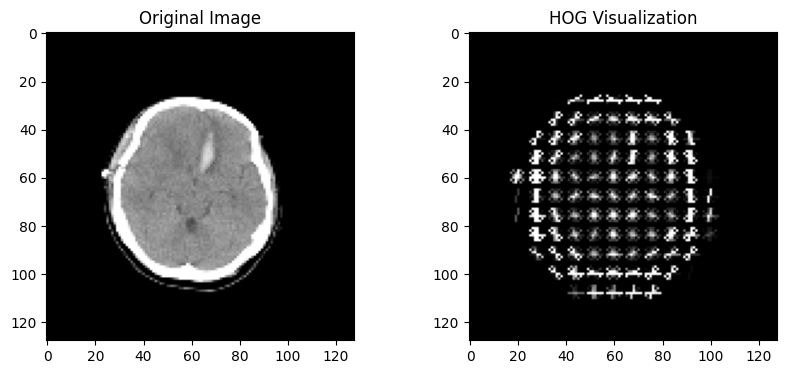

In [10]:
from skimage import exposure

test_gray = cv2.cvtColor(processed_images[0], cv2.COLOR_BGR2GRAY)

hog_img, hog_vis = hog(
    test_gray,
    orientations=9,
    pixels_per_cell=(8, 8),
    cells_per_block=(2, 2),
    visualize=True,
    block_norm="L2-Hys"
)

hog_vis = exposure.rescale_intensity(hog_vis, in_range=(0, 10))

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(test_gray, cmap="gray")
plt.title("Original Image")

plt.subplot(1,2,2)
plt.imshow(hog_vis, cmap="gray")
plt.title("HOG Visualization")
plt.show()


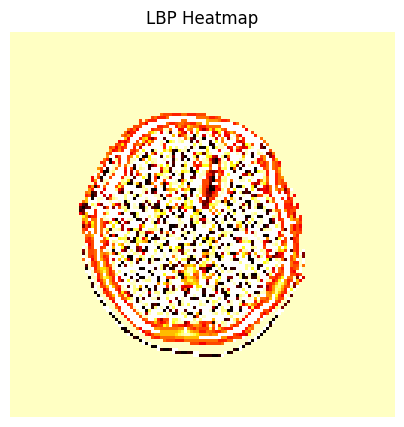

In [11]:
lbp_sample = local_binary_pattern(test_gray, LBP_POINTS, LBP_RADIUS, method='uniform')

plt.figure(figsize=(5,5))
plt.imshow(lbp_sample, cmap='hot')
plt.title("LBP Heatmap")
plt.axis("off")
plt.show()


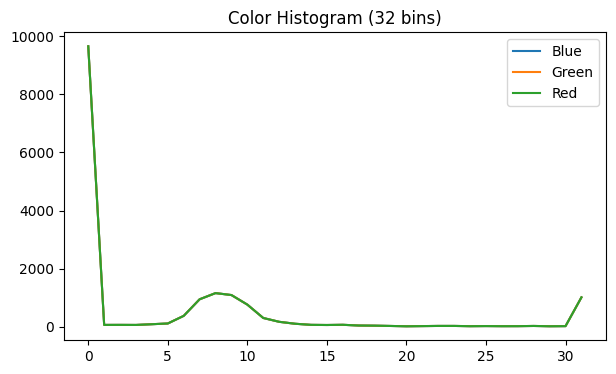

In [12]:
plt.figure(figsize=(7,4))
plt.plot(hist_b, label='Blue')
plt.plot(hist_g, label='Green')
plt.plot(hist_r, label='Red')
plt.title("Color Histogram (32 bins)")
plt.legend()
plt.show()

STEP 4 — Normalisasi & Penggabungan Fitur

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import numpy as np

scaler_hog = StandardScaler()
hog_norm = scaler_hog.fit_transform(hog_features)

scaler_lbp = StandardScaler()
lbp_norm = scaler_lbp.fit_transform(lbp_features)

scaler_color = MinMaxScaler()
color_norm = scaler_color.fit_transform(color_features)

X = np.concatenate([hog_norm, lbp_norm, color_norm], axis=1)

print("X shape (fitur akhir):", X.shape)
print("Total fitur per gambar:", X.shape[1])


X shape (fitur akhir): (6650, 8214)
Total fitur per gambar: 8214


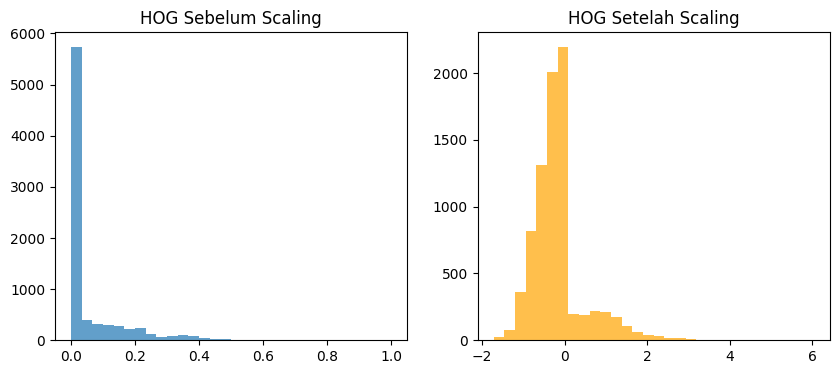

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(hog_features[0], bins=30, alpha=0.7)
plt.title("HOG Sebelum Scaling")

plt.subplot(1,2,2)
plt.hist(hog_norm[0], bins=30, alpha=0.7, color='orange')
plt.title("HOG Setelah Scaling")
plt.show()

c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


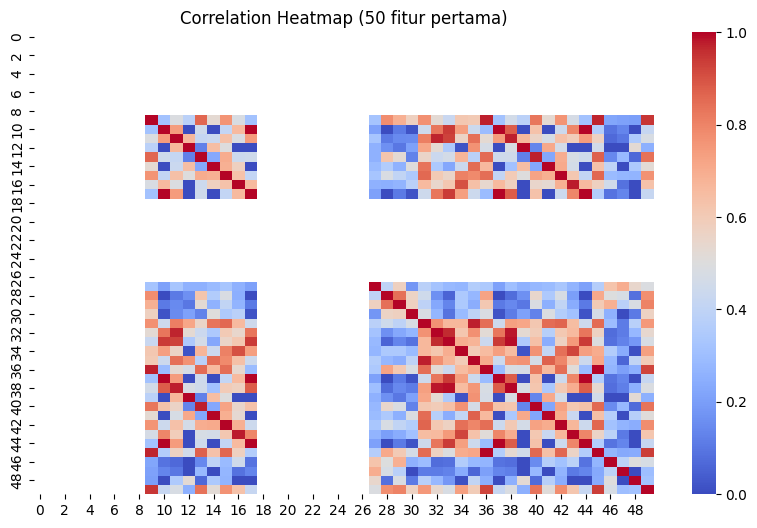

In [15]:
import seaborn as sns

plt.figure(figsize=(10,6))
sns.heatmap(np.corrcoef(X[:, :50].T), cmap="coolwarm")
plt.title("Correlation Heatmap (50 fitur pertama)")
plt.show()


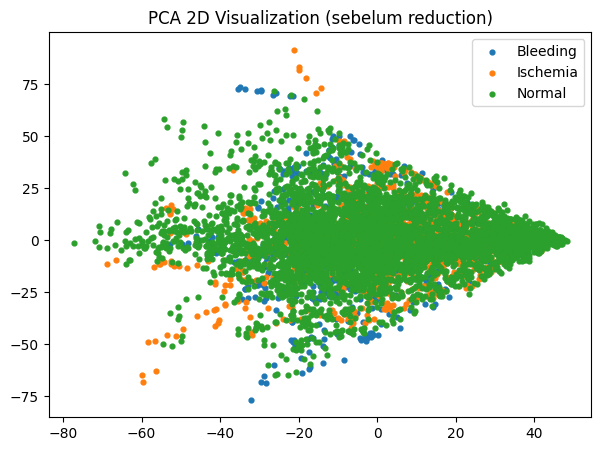

In [16]:
from sklearn.decomposition import PCA

pca_test = PCA(n_components=2)
X_2d = pca_test.fit_transform(X)

plt.figure(figsize=(7,5))
for cls in np.unique(labels):
    idx = np.where(labels == cls)
    plt.scatter(X_2d[idx,0], X_2d[idx,1], label=cls, s=12)

plt.title("PCA 2D Visualization (sebelum reduction)")
plt.legend()
plt.show()


STEP 5 — PCA (Reduksi Dimensi HOG → 200 fitur)

In [17]:
from sklearn.decomposition import PCA

PCA_COMPONENTS = 200

pca = PCA(n_components=PCA_COMPONENTS, random_state=42)
hog_pca = pca.fit_transform(hog_norm)

print("HOG PCA shape:", hog_pca.shape)
print("Total explained variance:", pca.explained_variance_ratio_.sum())


HOG PCA shape: (6650, 200)
Total explained variance: 0.5779802955037472


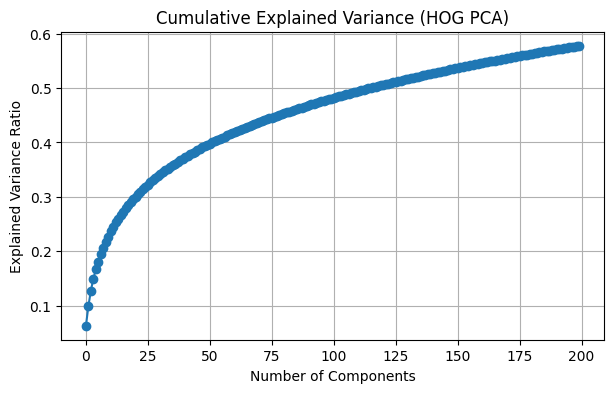

In [18]:
plt.figure(figsize=(7,4))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.title("Cumulative Explained Variance (HOG PCA)")
plt.xlabel("Number of Components")
plt.ylabel("Explained Variance Ratio")
plt.grid()
plt.show()


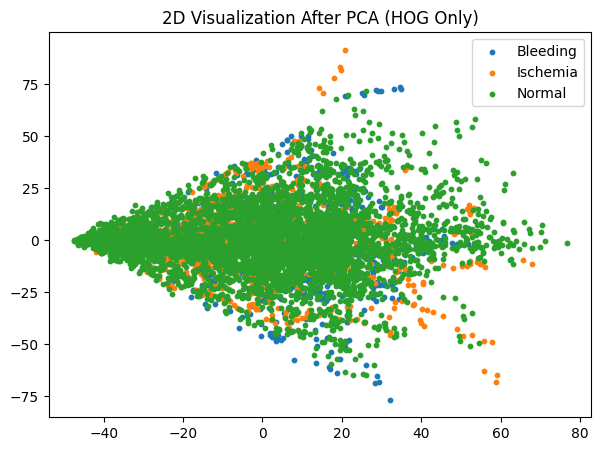

In [19]:
plt.figure(figsize=(7,5))

X_pca2 = PCA(n_components=2).fit_transform(hog_pca)

for cls in np.unique(labels):
    idx = np.where(labels == cls)
    plt.scatter(X_pca2[idx,0], X_pca2[idx,1], label=cls, s=10)

plt.title("2D Visualization After PCA (HOG Only)")
plt.legend()
plt.show()


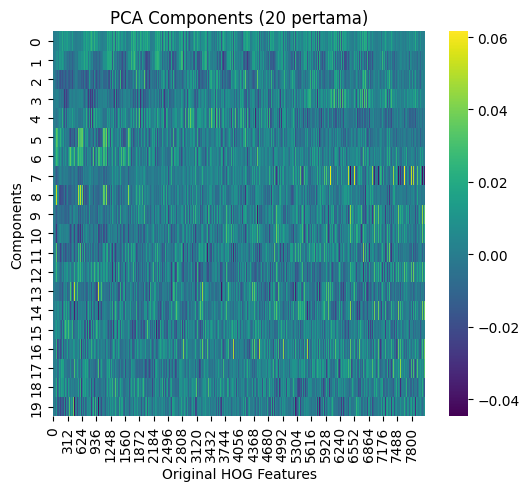

In [20]:
plt.figure(figsize=(6,5))
sns.heatmap(pca.components_[:20], cmap="viridis")
plt.title("PCA Components (20 pertama)")
plt.xlabel("Original HOG Features")
plt.ylabel("Components")
plt.show()


In [ ]:
X_final = np.concatenate([hog_pca, lbp_norm, color_norm], axis=1)

print("Final Feature Shape:", X_final.shape)

Final Feature Shape: (6650, 314)


STEP 6 — Stratified Train/Test Split (80/20)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y = le.fit_transform(labels)

X_train, X_test, y_train, y_test = train_test_split(
    X_final, y, 
    test_size=0.20, 
    stratify=y, 
    random_state=42
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

import numpy as np
unique, counts = np.unique(y_train, return_counts=True)
print("Train class distribution:", dict(zip(unique, counts)))

unique, counts = np.unique(y_test, return_counts=True)
print("Test class distribution:", dict(zip(unique, counts)))


Train shape: (5320, 314)
Test shape: (1330, 314)
Train class distribution: {np.int64(0): np.int64(874), np.int64(1): np.int64(904), np.int64(2): np.int64(3542)}
Test class distribution: {np.int64(0): np.int64(219), np.int64(1): np.int64(226), np.int64(2): np.int64(885)}


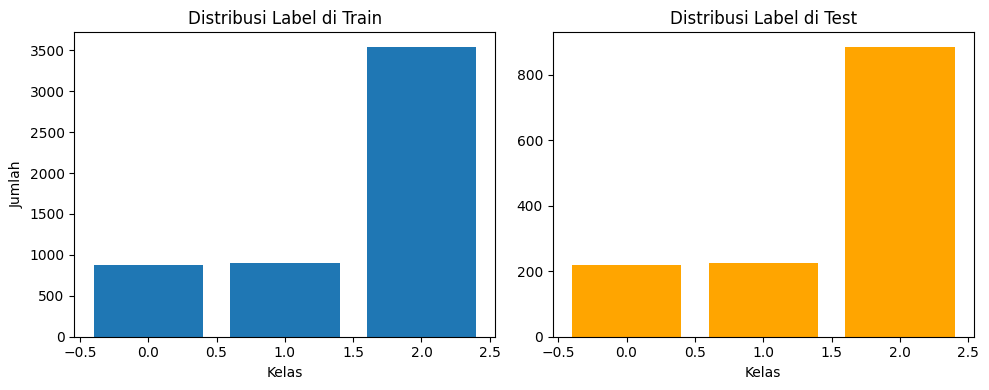

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.title("Distribusi Label di Train")
plt.bar(*np.unique(y_train, return_counts=True))
plt.xlabel("Kelas")
plt.ylabel("Jumlah")

plt.subplot(1,2,2)
plt.title("Distribusi Label di Test")
plt.bar(*np.unique(y_test, return_counts=True), color='orange')
plt.xlabel("Kelas")

plt.tight_layout()
plt.show()

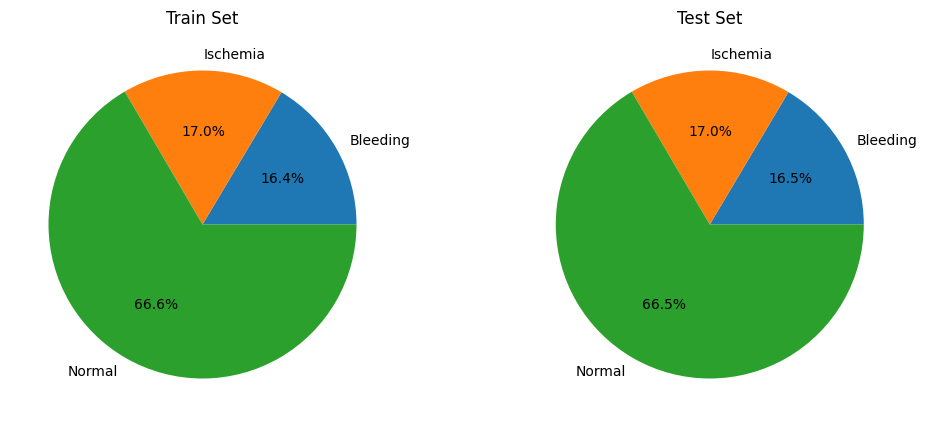

In [25]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.title("Train Set")
plt.pie(np.unique(y_train, return_counts=True)[1], labels=le.classes_, autopct='%1.1f%%')

plt.subplot(1,2,2)
plt.title("Test Set")
plt.pie(np.unique(y_test, return_counts=True)[1], labels=le.classes_, autopct='%1.1f%%')

plt.show()


STEP 7 — TRAINING 2 MODEL (SVM & XGBoost)

MODEL 1 — SVM (RBF Kernel)

In [26]:
from sklearn.svm import SVC

svm_clf = SVC(kernel='rbf', C=1.0, gamma='scale', probability=True)
svm_clf.fit(X_train, y_train)

print("SVM training selesai!")

SVM training selesai!


MODEL 2 — XGBoost (Baseline)

In [27]:
from xgboost import XGBClassifier

xgb_clf = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.9,
    colsample_bytree=0.9,
    eval_metric='mlogloss',
    random_state=42
)

xgb_clf.fit(X_train, y_train)

print("XGBoost training selesai!")


XGBoost training selesai!


STEP 7 — Evaluasi Awal (Akurasi / F1 / Confusion Matrix)


Evaluasi Model: SVM
Accuracy: 0.9105263157894737
F1-score (macro): 0.8758529075881561

Classification Report:
              precision    recall  f1-score   support

    Bleeding       0.98      0.74      0.84       219
    Ischemia       0.94      0.78      0.85       226
      Normal       0.89      0.99      0.94       885

    accuracy                           0.91      1330
   macro avg       0.94      0.83      0.88      1330
weighted avg       0.92      0.91      0.91      1330



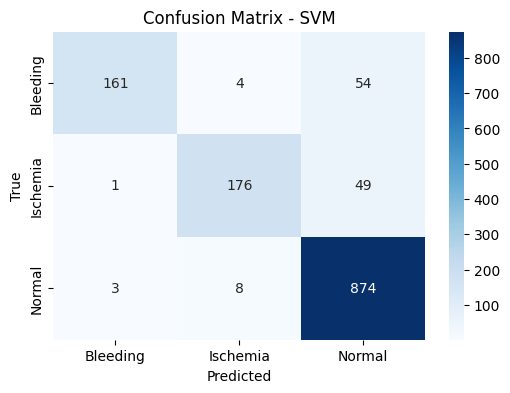


Evaluasi Model: XGBoost
Accuracy: 0.9285714285714286
F1-score (macro): 0.899315006680387

Classification Report:
              precision    recall  f1-score   support

    Bleeding       0.98      0.76      0.86       219
    Ischemia       0.97      0.81      0.89       226
      Normal       0.91      1.00      0.95       885

    accuracy                           0.93      1330
   macro avg       0.96      0.86      0.90      1330
weighted avg       0.93      0.93      0.93      1330



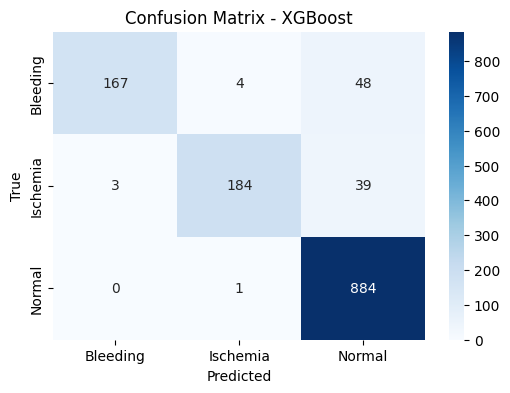

In [28]:
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

models = {
    "SVM": svm_clf,
    "XGBoost": xgb_clf
}

for name, model in models.items():
    print("\n==============================")
    print(f"Evaluasi Model: {name}")
    print("==============================")
    
    y_pred = model.predict(X_test)
    
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("F1-score (macro):", f1_score(y_test, y_pred, average='macro'))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=le.classes_))
    
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()


In [29]:
import pandas as pd

results = []

for name, model in models.items():
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')
    results.append([name, acc, f1])

df_results = pd.DataFrame(results, columns=["Model", "Accuracy", "F1 Score"])
print(df_results)


     Model  Accuracy  F1 Score
0      SVM  0.910526  0.875853
1  XGBoost  0.928571  0.899315


STEP 8 — Hyperparameter Tuning untuk XGBoost + SVM

CODE: HYPERPARAMETER TUNING SVM

In [30]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC

param_svm = {
    'C': [0.1, 1, 10, 50, 100],
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1],
    'kernel': ['rbf', 'poly', 'sigmoid']
}

svm_model = SVC(probability=True)

svm_search = RandomizedSearchCV(
    svm_model,
    param_distributions=param_svm,
    n_iter=20,
    scoring='f1_macro',
    cv=5,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

svm_search.fit(X_train, y_train)

print("Best SVM Params:", svm_search.best_params_)
print("Best SVM Score:", svm_search.best_score_)


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best SVM Params: {'kernel': 'poly', 'gamma': 'auto', 'C': 10}
Best SVM Score: 0.9401179881271464


CODE: HYPERPARAMETER TUNING XGBOOST

In [ ]:
from xgboost import XGBClassifier

param_xgb = {
    'n_estimators': [200, 300, 400, 600],
    'max_depth': [3, 5, 6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'min_child_weight': [1, 3, 5, 7]
}

xgb_model = XGBClassifier(eval_metric='mlogloss', random_state=42)

xgb_search = RandomizedSearchCV(
    xgb_model,
    param_distributions=param_xgb,
    n_iter=25,
    scoring='f1_macro',
    cv=5,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

xgb_search.fit(X_train, y_train)

print("Best XGBoost Params:", xgb_search.best_params_)
print("Best XGBoost CV Score:", xgb_search.best_score_)


Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best XGBoost Params: {'subsample': 0.7, 'n_estimators': 600, 'min_child_weight': 3, 'max_depth': 8, 'learning_rate': 0.1, 'colsample_bytree': 0.7}
Best XGBoost CV Score: 0.885197980266096


In [ ]:
best_svm = svm_search.best_estimator_
best_xgb = xgb_search.best_estimator_

EVALUASI TUNING



SVM (Tuned)

Accuracy: 0.9774436090225563
F1 Score: 0.9701829160625999

Classification Report:
              precision    recall  f1-score   support

    Bleeding       0.99      0.94      0.96       219
    Ischemia       0.99      0.94      0.97       226
      Normal       0.97      1.00      0.98       885

    accuracy                           0.98      1330
   macro avg       0.98      0.96      0.97      1330
weighted avg       0.98      0.98      0.98      1330



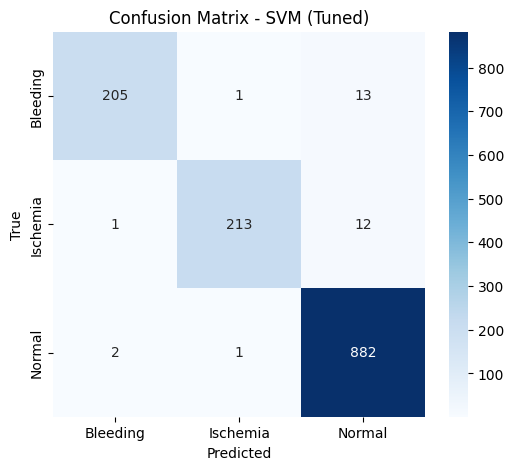



XGBoost (Tuned)

Accuracy: 0.9308270676691729
F1 Score: 0.9023732823732824

Classification Report:
              precision    recall  f1-score   support

    Bleeding       0.97      0.78      0.86       219
    Ischemia       0.98      0.81      0.89       226
      Normal       0.92      1.00      0.95       885

    accuracy                           0.93      1330
   macro avg       0.95      0.86      0.90      1330
weighted avg       0.93      0.93      0.93      1330



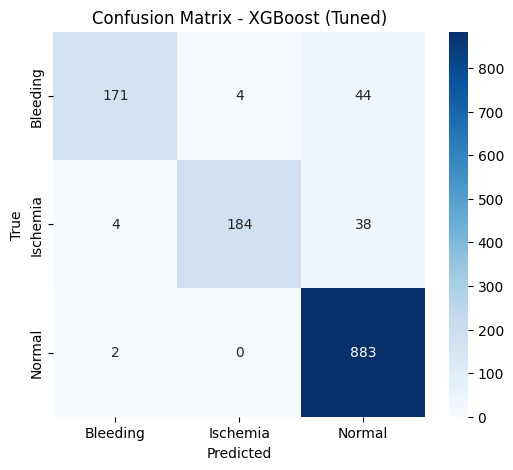

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

models = {
    "SVM (Tuned)": best_svm,
    "XGBoost (Tuned)": best_xgb
}

for name, model in models.items():
    print("\n")
    print(name)
    print("")
    
    y_pred = model.predict(X_test)

    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("F1 Score:", f1_score(y_test, y_pred, average='macro'))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=le.classes_))
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, cmap="Blues", fmt="d",
                xticklabels=le.classes_,
                yticklabels=le.classes_)
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()


In [35]:
import pandas as pd

results = []

for name, model in models.items():
    y_pred = model.predict(X_test)
    results.append([
        name,
        accuracy_score(y_test, y_pred),
        f1_score(y_test, y_pred, average='macro')
    ])

df_results = pd.DataFrame(results, columns=["Model", "Accuracy", "F1 Score"])
print(df_results)


             Model  Accuracy  F1 Score
0      SVM (Tuned)  0.977444  0.970183
1  XGBoost (Tuned)  0.930827  0.902373


STEP 9 - Evaluasi Lengkap

In [ ]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, roc_auc_score,
    roc_curve, auc, precision_recall_curve
)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def evaluate_model(model, X_test, y_test, model_name="Model"):

    y_pred = model.predict(X_test)
    classes = np.unique(y_test)
    n_classes = len(classes)

    if n_classes == 2:
        y_prob = model.predict_proba(X_test)[:, 1]  

        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred, average='binary')
        rec = recall_score(y_test, y_pred, average='binary')
        f1 = f1_score(y_test, y_pred, average='binary')

        print(f"\n=== {model_name} ===")
        print(f"Accuracy  : {acc:.4f}")
        print(f"Precision : {prec:.4f}")
        print(f"Recall    : {rec:.4f}")
        print(f"F1 Score  : {f1:.4f}")
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred))

        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(5,4))
        sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
        plt.title(f"Confusion Matrix - {model_name}")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.show()

        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)

        plt.figure(figsize=(6,5))
        plt.plot(fpr, tpr, lw=2, label=f"AUC = {roc_auc:.4f}")
        plt.plot([0,1],[0,1], 'k--')
        plt.title(f"ROC Curve - {model_name}")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.legend()
        plt.show()

        precision, recall, thresh = precision_recall_curve(y_test, y_prob)
        plt.figure(figsize=(6,5))
        plt.plot(recall, precision, lw=2)
        plt.title(f"Precision-Recall Curve - {model_name}")
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.show()

        return acc, prec, rec, f1

    else:
        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred, average='macro')
        rec = recall_score(y_test, y_pred, average='macro')
        f1 = f1_score(y_test, y_pred, average='macro')

        print(f"\n=== {model_name} (Multiclass) ===")
        print(f"Accuracy  : {acc:.4f}")
        print(f"Precision : {prec:.4f}")
        print(f"Recall    : {rec:.4f}")
        print(f"F1 Score  : {f1:.4f}")
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred))

        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(5,4))
        sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
        plt.title(f"Confusion Matrix - {model_name}")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.show()

        print("\n(ROC Curve & Precision-Recall Curve dilewati karena multiclass)")

        return acc, prec, rec, f1



=== SVM (Tuned) (Multiclass) ===
Accuracy  : 0.9774
Precision : 0.9829
Recall    : 0.9584
F1 Score  : 0.9702

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.94      0.96       219
           1       0.99      0.94      0.97       226
           2       0.97      1.00      0.98       885

    accuracy                           0.98      1330
   macro avg       0.98      0.96      0.97      1330
weighted avg       0.98      0.98      0.98      1330



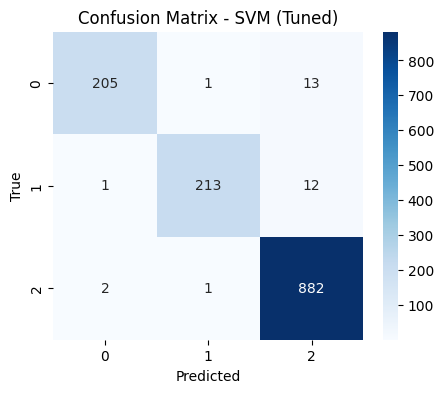


(ROC Curve & Precision-Recall Curve dilewati karena multiclass)


In [41]:
svm_results = evaluate_model(best_svm, X_test, y_test, model_name="SVM (Tuned)")


=== XGBoost (Tuned) (Multiclass) ===
Accuracy  : 0.9308
Precision : 0.9533
Recall    : 0.8642
F1 Score  : 0.9024

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.78      0.86       219
           1       0.98      0.81      0.89       226
           2       0.92      1.00      0.95       885

    accuracy                           0.93      1330
   macro avg       0.95      0.86      0.90      1330
weighted avg       0.93      0.93      0.93      1330



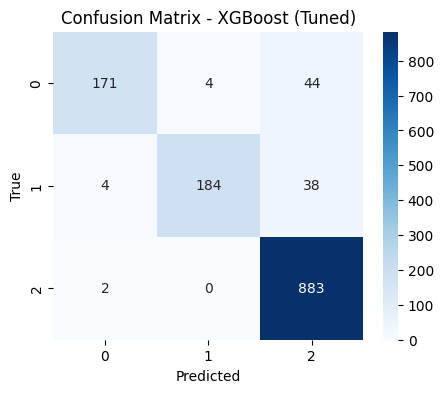


(ROC Curve & Precision-Recall Curve dilewati karena multiclass)


In [42]:
xgb_results = evaluate_model(best_xgb, X_test, y_test, model_name="XGBoost (Tuned)")

STEP 10 - Model Comparison Table + VISUALISASI TAMBAHAN

             Model  Accuracy  Precision    Recall  F1 Score
0      SVM (Tuned)  0.977444   0.982904  0.958387  0.970183
1  XGBoost (Tuned)  0.930827   0.953284  0.864240  0.902373


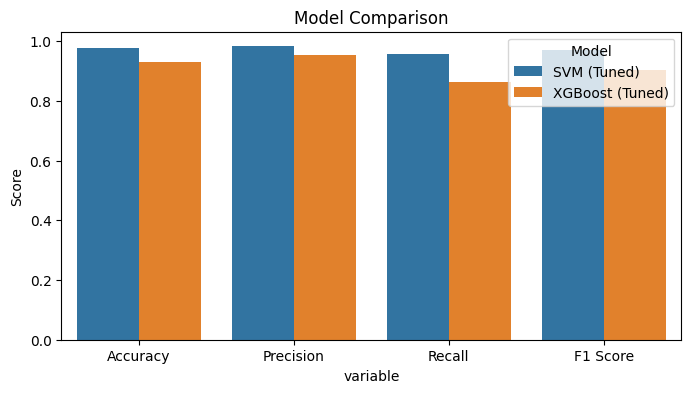

In [43]:
import pandas as pd

results_df = pd.DataFrame({
    "Model": ["SVM (Tuned)", "XGBoost (Tuned)"],
    "Accuracy": [svm_results[0], xgb_results[0]],
    "Precision": [svm_results[1], xgb_results[1]],
    "Recall": [svm_results[2], xgb_results[2]],
    "F1 Score": [svm_results[3], xgb_results[3]]
})

print(results_df)

plt.figure(figsize=(8,4))
sns.barplot(data=results_df.melt(id_vars="Model"), x="variable", y="value", hue="Model")
plt.title("Model Comparison")
plt.ylabel("Score")
plt.show()


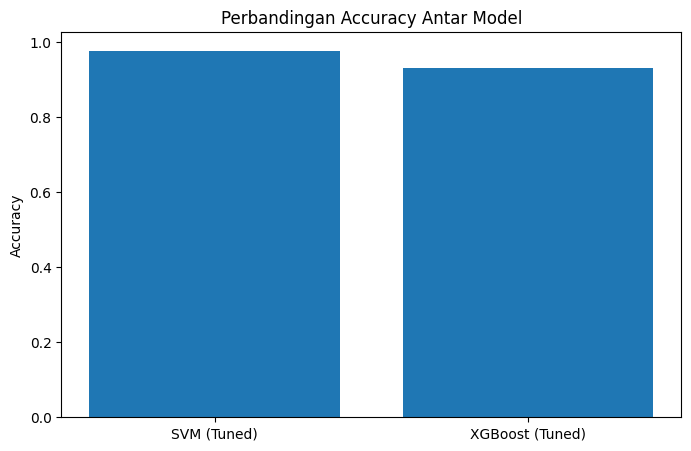

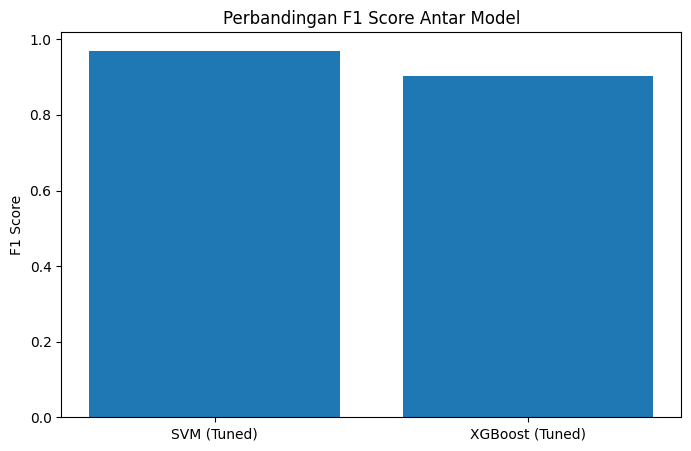

In [66]:
plt.figure(figsize=(8,5))
plt.bar(df_results['Model'], df_results['Accuracy'])
plt.title("Perbandingan Accuracy Antar Model")
plt.ylabel("Accuracy")
plt.show()

plt.figure(figsize=(8,5))
plt.bar(df_results['Model'], df_results['F1 Score'])
plt.title("Perbandingan F1 Score Antar Model")
plt.ylabel("F1 Score")
plt.show()

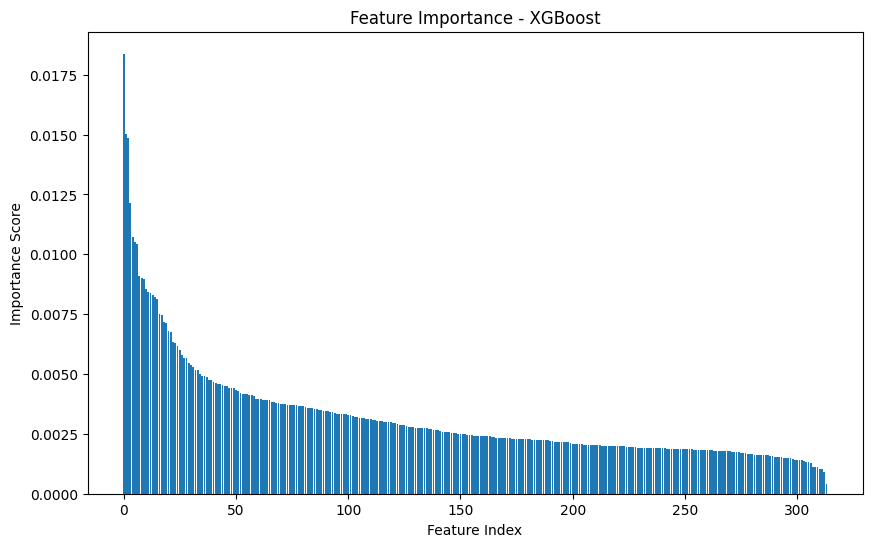

In [67]:
import numpy as np

xgb = best_xgb
importances = xgb.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10,6))
plt.bar(range(len(importances)), importances[indices])
plt.title("Feature Importance - XGBoost")
plt.xlabel("Feature Index")
plt.ylabel("Importance Score")
plt.show()

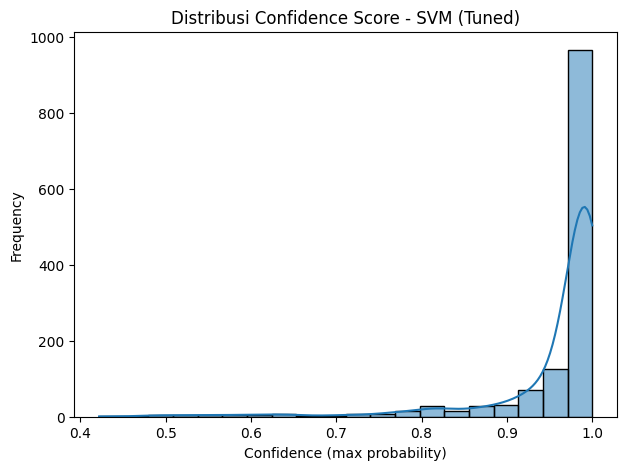

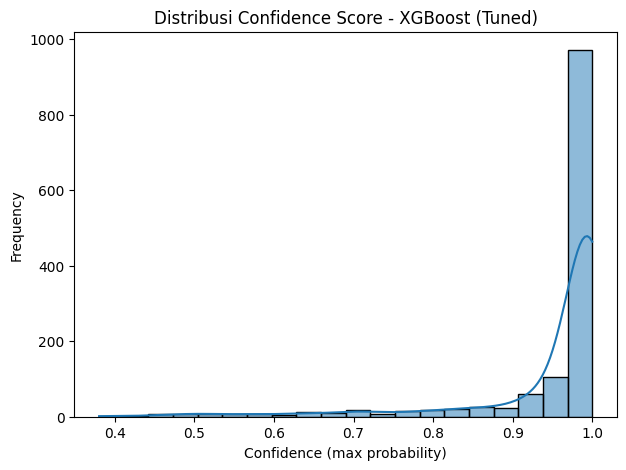

In [68]:
for name, model in models.items():
    y_prob = model.predict_proba(X_test)
    max_conf = np.max(y_prob, axis=1)

    plt.figure(figsize=(7,5))
    sns.histplot(max_conf, bins=20, kde=True)
    plt.title(f"Distribusi Confidence Score - {name}")
    plt.xlabel("Confidence (max probability)")
    plt.ylabel("Frequency")
    plt.show()

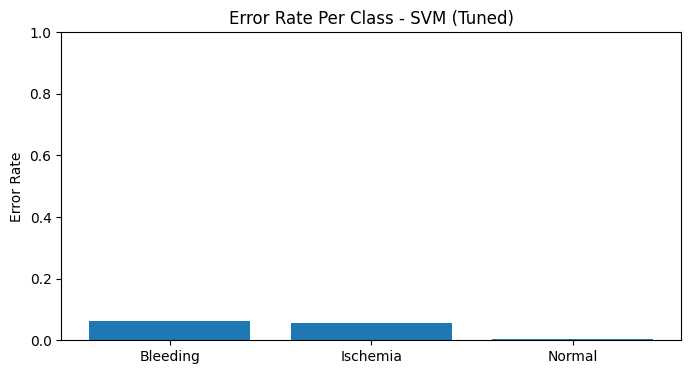

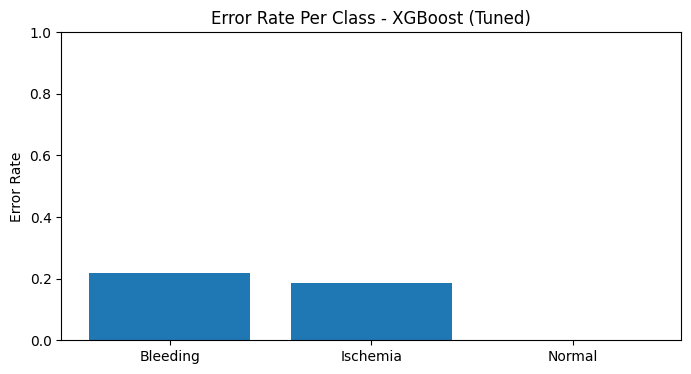

In [71]:
for name, model in models.items():
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    errors = 1 - np.diag(cm) / np.sum(cm, axis=1)

    plt.figure(figsize=(8,4))
    plt.bar(le.classes_, errors)
    plt.title(f"Error Rate Per Class - {name}")
    plt.ylabel("Error Rate")
    plt.ylim(0,1)
    plt.show()

TAMBAHAN BUAT DI LAPORAN

In [ ]:
# ini hanya dibuat insight aja, seperti contoh insight hasil
import cv2
import matplotlib.pyplot as plt

def display_single_prediction(img_path, true_label, pred_label):
    img = cv2.imread(img_path)
    if img is None:
        print("Gambar tidak ditemukan:", img_path)
        return
    
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    title_color = 'green' if true_label == pred_label else 'red'

    plt.figure(figsize=(6, 6))
    plt.imshow(img_rgb)
    plt.title(f"Actual: {true_label}\nPredict: {pred_label}",
              color=title_color, fontweight='bold', fontsize=14)
    plt.axis('off')
    plt.show()

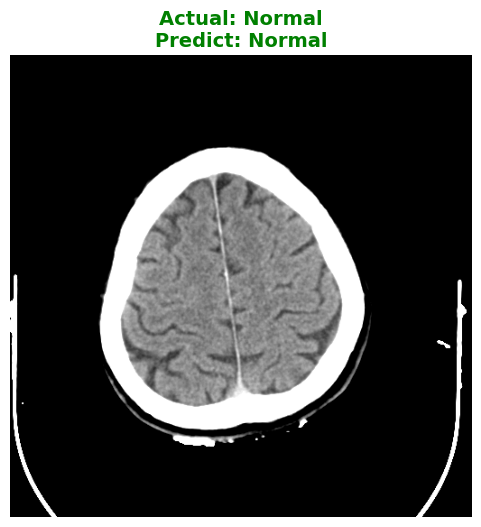

In [ ]:
img_path = r"C:\Users\LENOVO\Downloads\KA\Brain_Stroke_CT_Dataset\Normal\10000.png"

true_label = "Normal"
pred_label = "Normal"    

display_single_prediction(img_path, true_label, pred_label)
